In [47]:
%matplotlib inline
import sys
sys.path.append('C:/bigARTM/python')
import artm
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')
print artm.version()

import numpy as np
import matplotlib.pyplot as plt
import random, os, timeit
from itertools import product
from collections import defaultdict
from sklearn.preprocessing import maxabs_scale

from IPython.display import clear_output

from mpl_toolkits.mplot3d import Axes3D

0.8.2


In [2]:
'''batch_vectorizer = artm.BatchVectorizer(data_path='datasets/kos/',
                                        data_format='bow_uci',
                                        collection_name='kos',
                                        target_folder='datasets/kos/batches', 
                                        vocab_file_path='datasets/kos/vocab.kos.txt')'''

batch_vectorizer = artm.BatchVectorizer(data_path='datasets/kos/batches', data_format='batches')
# dictionary = artm.Dictionary()
# dictionary.gather(data_path='datasets/kos/batches', vocab_file_path='datasets/kos/vocab.kos.txt')
#batch_vectorizer = artm.BatchVectorizer(data_path='datasets/nips/batches', data_format='batches')
#batch_vectorizer = artm.BatchVectorizer(data_path='datasets/enron/batches', data_format='batches')
#batch_vectorizer = artm.BatchVectorizer(data_path='datasets/nytimes/batches', data_format='batches')

print "kos wd_matrix size: {}x{}".format(6906, 3430)
print "nips wd_matrix size: {}x{}".format(12375, 1500)
print "enron wd_matrix size: {}x{}".format(28099, 39861)
print "nytimes wd_matrix size: {}x{}".format(101636, 299752)

kos wd_matrix size: 6906x3430
nips wd_matrix size: 12375x1500
enron wd_matrix size: 28099x39861
nytimes wd_matrix size: 101636x299752


In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path='datasets/kos/',
                                        data_format='bow_uci',
                                        collection_name='kos',
                                        target_folder='datasets/kos/batches', 
                                        vocabulary='datasets/kos/vocab.kos.txt')

# batch_vectorizer = artm.BatchVectorizer(data_path='datasets/kos/batches', data_format='batches')
# dictionary = artm.Dictionary()
# dictionary.gather(data_path='datasets/kos/batches', vocab_file_path='datasets/kos/vocab.kos.txt')

In [37]:
def jaccard_index(a, b):
    return len(a.intersection(b)) / float(len(a.union(b)))

In [26]:
def top_words_by_phi(phi):
    '''
    finds all word indices with probability in phi greater than 1/n_words (at least in 1 topic)
    '''
    n_words = phi.shape[0]
    return list(np.arange(n_words)[np.max(phi, axis=1) > 1. / n_words])

In [82]:
def top_words_experiment(collection_name, max_topics):
    if collection_name not in ["kos", "nips", "enron", "nytimes"]:
        raise ValueError("unknown collection {}".format(collection_name))
    batch_vectorizer = artm.BatchVectorizer(data_path='datasets/{}/'.format(collection_name),
                                        data_format='bow_uci',
                                        collection_name='{}'.format(collection_name),
                                        target_folder='datasets/{}/batches'.format(collection_name), 
                                        vocabulary='datasets/{}/vocab.{}.txt'.format(collection_name, collection_name))
    
    top_words = {}
    for n_topics in range(1, max_topics):
        model = artm.ARTM(num_topics=n_topics, dictionary=batch_vectorizer.dictionary, seed=42, cache_theta=True)
        model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
        top_words[n_topics] = set(top_words_by_phi(model.phi_.values))
        clear_output()
    return top_words

In [91]:
def draw_jaccard(top_words, collection_name=None):
    max_topics = len(top_words.keys()) + 1
    jaccards = []
    for i in range(1, max_topics - 1):
        jaccards.append(jaccard_index(top_words[i], top_words[i + 1]))
    plt.plot(jaccards)
    plt.show()
    
    jaccards_3d = []
    for i, j in product(range(1, MAX_TOPICS - 1), range(1, max_topics - 1)):
        jaccards_3d.append((i, j, jaccard_index(top_words[i], top_words[j])))
        
    step = 0.2; colors = ["red", "blue", "green", "yellow", "black"]
    if len(np.arange(0, 1, step)) != len(colors):
        raise ValueError("Colors number must equal number of steps to draw.")
    plt.figure(figsize=(18, 10))
    if collection_name:
        plt.title("jaccard between top words, collection: {}".format(collection_name))
    for color_i, lim in enumerate(np.arange(0, 1, step)):
        points_x = [i for i, j, jac in jaccards_3d if lim <= jac < lim + step]
        points_y = [j for i, j, jac in jaccards_3d if lim <= jac < lim + step]
        plt.scatter(points_x, points_y, c=colors[color_i], label="[{}: {}]".format(lim, lim+step))
    plt.legend()
    plt.show()

In [97]:
top_words_kos = top_words_experiment("kos", 100)

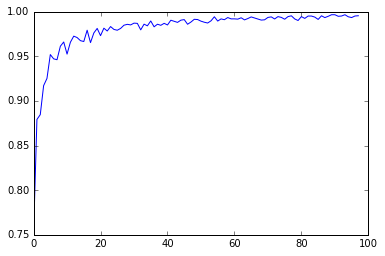

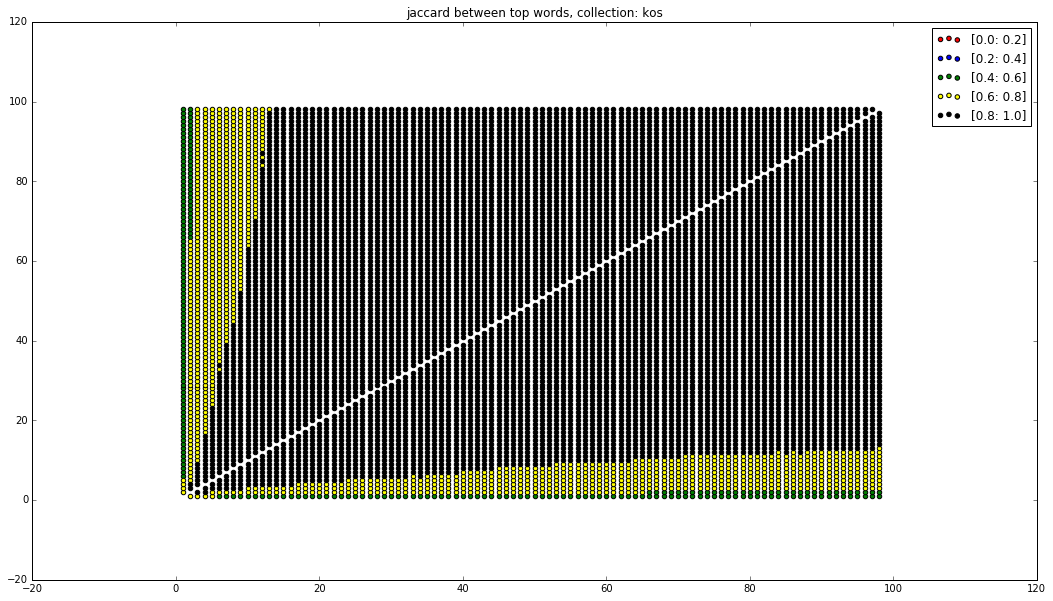

In [98]:
draw_jaccard(top_words_kos, "kos")

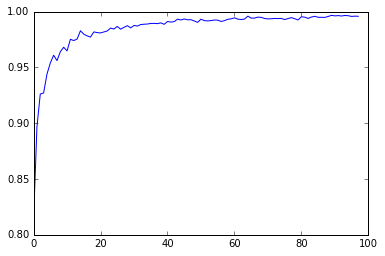

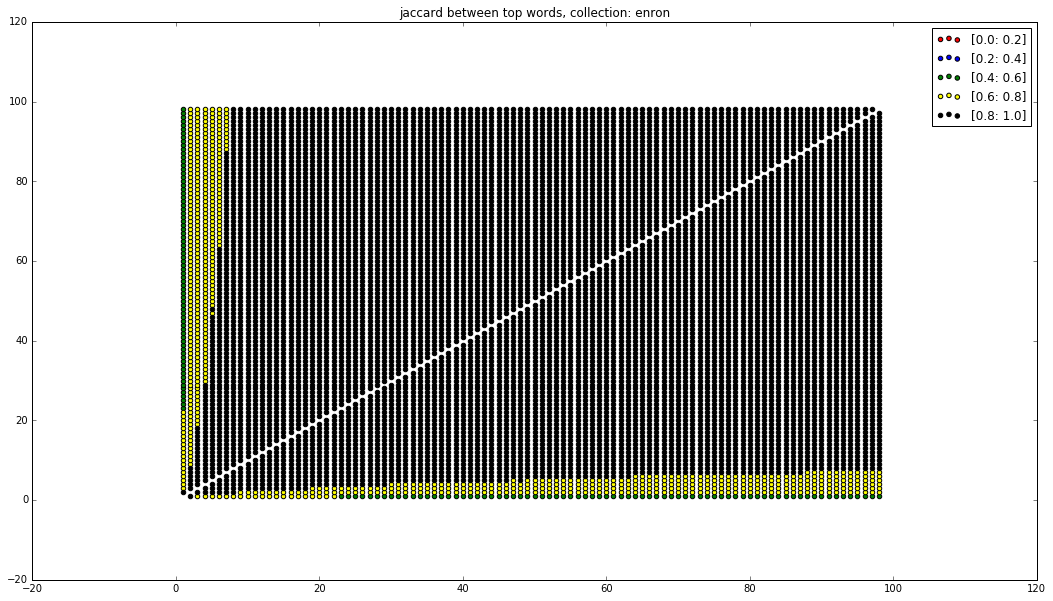

In [94]:
collection_name = "enron"
top_words_kos = top_words_experiment(collection_name, 100)
draw_jaccard(top_words_kos, collection_name)

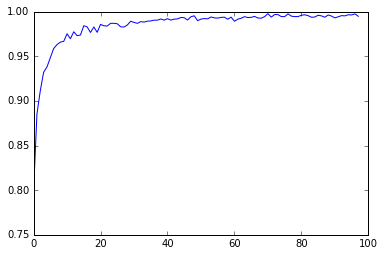

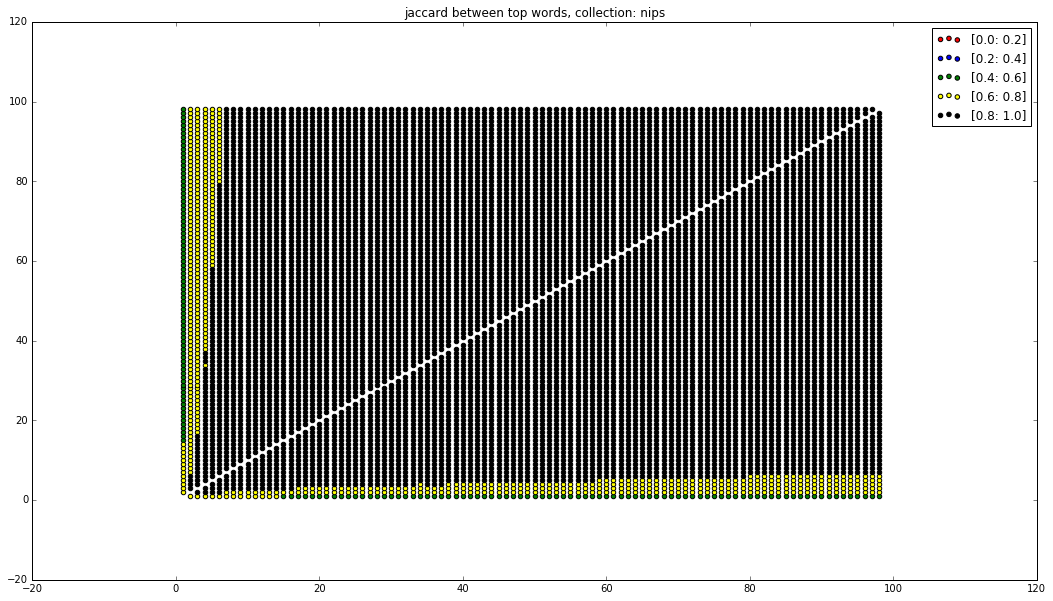

In [95]:
collection_name = "nips"
top_words_kos = top_words_experiment(collection_name, 100)
draw_jaccard(top_words_kos, collection_name)